In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import cv2

import torch
import torchvision
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable
import torch.nn.functional as F

from flashtorch.utils import apply_transforms, load_image 
import net

In [2]:
def custom_transform(pil_image):
    """Custom transform incorporating face alignment and preprocessing."""
    #aligned_rgb_img = align.get_aligned_face(pil_image)
    np_img = np.array(pil_image)
    bgr_img = ((np_img[:, :, ::-1] / 255.0) - 0.5) / 0.5  # Normalize to [-1, 1]
    tensor = torch.tensor(bgr_img.transpose(2, 0, 1)).float()
    return tensor

In [3]:
 def get_input_tensors(img):
    
    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Lambda(lambda img: custom_transform(img)),
    # Add more transformations if needed (e.g., data augmentation)
    ])
    
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)
    

In [4]:
 def get_input_tensors_no_resize(img):
    
    # Define transformations
    transform = transforms.Compose([
    #transforms.Resize((112, 112)),
    transforms.Lambda(lambda img: custom_transform(img)),
    # Add more transformations if needed (e.g., data augmentation)
    ])
    
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)
    

In [5]:
 def get_input_tensors_single(img):
    
    # Define transformations
    transform = transforms.Compose([
    #transforms.Resize((112, 112)),
    transforms.Lambda(lambda img: custom_transform(img)),
    # Add more transformations if needed (e.g., data augmentation)
    ])
    
    # unsqeeze converts single image to batch of 1
    return transform(img)
    

In [6]:
#Define the path to pretrained AdaFace models
adaface_models = {
    'ir_101': "models/adaface_ir101_webface12m.ckpt",
}

def load_pretrained_model(architecture='ir_101'):
    """Load the pretrained AdaFace model."""
    assert architecture in adaface_models.keys(), f"Architecture {architecture} not supported."
    model = net.build_model(architecture)
    statedict = torch.load(adaface_models[architecture])['state_dict']
    # Remove 'model.' prefix from keys
    model_statedict = {key[6:]: val for key, val in statedict.items() if key.startswith('model.')}
    model.load_state_dict(model_statedict)
    model.eval()  # Set to evaluation mode
    return model
    
    
class FaceClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, freeze_feature_extractor=True):
        super(FaceClassifier, self).__init__()
        self.feature_extractor = load_pretrained_model('ir_101')
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.feature_dim, self.num_classes)

        if freeze_feature_extractor:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False  # Freeze feature extractor
        #else:
             # Unfreeze the feature extractor
            #for param in self.feature_extractor.parameters():
                #param.requires_grad = True

    def forward(self, x):
        with torch.no_grad():
            features, _ = self.feature_extractor(x)
        #print(type(features))
        out = self.classifier(features)
        return out

In [7]:

import io 

import scipy.ndimage as nd 

from flashtorch.saliency import Backprop 
from flashtorch.activmax import GradientAscent 

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()


In [9]:
def get_class_cam(model, output, activations, class_index):
    # remove batch and transpose to 7,7,2048
    out_features = activations.output.squeeze(0)
    out_features = np.transpose(out_features.cpu().detach(), (1,2,0))
    fw = model.classifier.weight[class_index,:]
    cam = np.dot(out_features.detach(), fw.detach().cpu())
    return cam


In [10]:
def get_score_cam(model, input_tensor, target_class, activations):
    """
    Generate Score-CAM for a specific class.
    
    Args:
        model (torch.nn.Module): The classification model.
        input_tensor (torch.Tensor): Input image tensor of shape (1, C, H, W).
        target_class (int): The target class index.
        activations: Hook object containing feature maps from the target layer.

    Returns:
        np.ndarray: Score-CAM heatmap.
    """
    with torch.no_grad():
        # Get activation maps from hook (shape: [C, H, W])
        act = activations.output.squeeze(0)  # Remove batch dim
        num_channels, h, w = act.shape

        # Normalize activation maps to [0, 1]
        min_vals = torch.amin(act, dim=(1, 2), keepdim=True)
        max_vals = torch.amax(act, dim=(1, 2), keepdim=True)
        act = (act - min_vals) / (max_vals - min_vals + 1e-8)

        # Resize each activation map to input size (H, W)
        _, _, H, W = input_tensor.shape
        upsampled_acts = F.interpolate(act.unsqueeze(0), size=(H, W), mode='bilinear', align_corners=False)
        
        weights = []
        for i in range(num_channels):
            masked_input = input_tensor * upsampled_acts[0, i:i+1, :, :]
            output = model(masked_input)
            score = F.softmax(output, dim=1)[0, target_class].item()
            weights.append(score)
        
        weights = np.array(weights).reshape(-1, 1, 1)
        cam = (act.cpu().numpy() * weights).sum(axis=0)


        cam = np.maximum(cam, 0)  # ReLU
        #cam = cam - np.min(cam)
        #cam = cam / (np.max(cam) + 1e-8)  # Normalize to [0, 1]
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam


In [11]:
def show_sub_plots_op(original, activations, pclasses):
    n = len(activations)
    f, axarr = plt.subplots(1, n, figsize=(n * 5, 5))
    
    # Reverse the custom transformation to display the original image properly
    inp = torch.squeeze(original, 0).numpy().transpose((1, 2, 0))  # Change to (H, W, C)
    inp = ((inp * 0.5) + 0.5) * 255  # De-normalize from [-1, 1] to [0, 255]
    inp = inp[:, :, ::-1]  # Convert back from BGR to RGB
    inp = np.clip(inp / 255.0, 0, 1)  # Normalize to [0, 1] for display
    
    # Display each activation map with the original image as background
    for i, cam in enumerate(activations):
        axarr[i].axis('off')
        axarr[i].imshow(inp, cmap='jet', alpha=1)
        axarr[i].set_title(pclasses[i])
        
        # Calculate zoom factor based on the original and cam dimensions
        orig_h, orig_w = inp.shape[:2]
        cam_h, cam_w = cam.shape
        zoom_factor = (orig_h / cam_h, orig_w / cam_w)
        
        # Rescale the activation map
        zcam = nd.zoom(cam, zoom=zoom_factor, order=1)
        axarr[i].imshow(zcam, cmap='jet', alpha=0.4)
    
    # Add a short pause for the plot to render
    plt.pause(0.001)


In [12]:
class_names = ['subject_1', 'subject_10', 'subject_100', 'subject_101', 'subject_102', 'subject_103', 'subject_104', 'subject_105', 'subject_106', 'subject_107', 'subject_108', 'subject_109', 'subject_11', 'subject_110', 'subject_111', 'subject_112', 'subject_113', 'subject_114', 'subject_115', 'subject_116', 'subject_117', 'subject_118', 'subject_119', 'subject_12', 'subject_120', 'subject_121', 'subject_122', 'subject_123', 'subject_124', 'subject_125', 'subject_126', 'subject_127', 'subject_128', 'subject_129', 'subject_13', 'subject_130', 'subject_131', 'subject_132', 'subject_133', 'subject_134', 'subject_135', 'subject_136', 'subject_137', 'subject_138', 'subject_139', 'subject_14', 'subject_140', 'subject_141', 'subject_142', 'subject_143', 'subject_144', 'subject_145', 'subject_146', 'subject_147', 'subject_148', 'subject_149', 'subject_15', 'subject_150', 'subject_151', 'subject_152', 'subject_153', 'subject_154', 'subject_155', 'subject_156', 'subject_157', 'subject_158', 'subject_159', 'subject_16', 'subject_160', 'subject_161', 'subject_162', 'subject_163', 'subject_164', 'subject_165', 'subject_166', 'subject_167', 'subject_168', 'subject_169', 'subject_17', 'subject_170', 'subject_171', 'subject_172', 'subject_173', 'subject_174', 'subject_175', 'subject_176', 'subject_177', 'subject_178', 'subject_179', 'subject_18', 'subject_180', 'subject_181', 'subject_182', 'subject_183', 'subject_184', 'subject_185', 'subject_186', 'subject_187', 'subject_188', 'subject_189', 'subject_19', 'subject_190', 'subject_191', 'subject_192', 'subject_193', 'subject_194', 'subject_195', 'subject_196', 'subject_197', 'subject_198', 'subject_199', 'subject_2', 'subject_20', 'subject_200', 'subject_201', 'subject_202', 'subject_203', 'subject_204', 'subject_205', 'subject_206', 'subject_207', 'subject_208', 'subject_209', 'subject_21', 'subject_210', 'subject_211', 'subject_212', 'subject_213', 'subject_214', 'subject_215', 'subject_216', 'subject_217', 'subject_218', 'subject_219', 'subject_22', 'subject_220', 'subject_221', 'subject_222', 'subject_223', 'subject_224', 'subject_225', 'subject_226', 'subject_227', 'subject_228', 'subject_229', 'subject_23', 'subject_230', 'subject_231', 'subject_232', 'subject_233', 'subject_234', 'subject_235', 'subject_236', 'subject_237', 'subject_238', 'subject_239', 'subject_24', 'subject_240', 'subject_241', 'subject_242', 'subject_243', 'subject_244', 'subject_245', 'subject_246', 'subject_247', 'subject_248', 'subject_249', 'subject_25', 'subject_250', 'subject_251', 'subject_252', 'subject_253', 'subject_254', 'subject_255', 'subject_256', 'subject_257', 'subject_258', 'subject_259', 'subject_26', 'subject_260', 'subject_261', 'subject_262', 'subject_263', 'subject_264', 'subject_265', 'subject_266', 'subject_267', 'subject_268', 'subject_269', 'subject_27', 'subject_270', 'subject_271', 'subject_272', 'subject_273', 'subject_274', 'subject_275', 'subject_276', 'subject_277', 'subject_278', 'subject_279', 'subject_28', 'subject_280', 'subject_281', 'subject_282', 'subject_283', 'subject_284', 'subject_285', 'subject_286', 'subject_287', 'subject_288', 'subject_289', 'subject_29', 'subject_290', 'subject_291', 'subject_292', 'subject_293', 'subject_294', 'subject_295', 'subject_296', 'subject_297', 'subject_298', 'subject_299', 'subject_3', 'subject_30', 'subject_300', 'subject_301', 'subject_302', 'subject_303', 'subject_304', 'subject_305', 'subject_306', 'subject_307', 'subject_308', 'subject_309', 'subject_31', 'subject_310', 'subject_311', 'subject_312', 'subject_313', 'subject_314', 'subject_315', 'subject_316', 'subject_317', 'subject_318', 'subject_319', 'subject_32', 'subject_320', 'subject_321', 'subject_322', 'subject_323', 'subject_324', 'subject_325', 'subject_326', 'subject_327', 'subject_328', 'subject_329', 'subject_33', 'subject_330', 'subject_331', 'subject_332', 'subject_333', 'subject_334', 'subject_335', 'subject_336', 'subject_337', 'subject_338', 'subject_339', 'subject_34', 'subject_340', 'subject_341', 'subject_342', 'subject_343', 'subject_344', 'subject_345', 'subject_346', 'subject_347', 'subject_348', 'subject_349', 'subject_35', 'subject_350', 'subject_351', 'subject_352', 'subject_353', 'subject_354', 'subject_355', 'subject_356', 'subject_357', 'subject_358', 'subject_359', 'subject_36', 'subject_360', 'subject_361', 'subject_362', 'subject_363', 'subject_364', 'subject_365', 'subject_366', 'subject_367', 'subject_368', 'subject_369', 'subject_37', 'subject_370', 'subject_371', 'subject_372', 'subject_373', 'subject_374', 'subject_375', 'subject_376', 'subject_377', 'subject_378', 'subject_379', 'subject_38', 'subject_380', 'subject_381', 'subject_382', 'subject_383', 'subject_384', 'subject_385', 'subject_386', 'subject_387', 'subject_388', 'subject_389', 'subject_39', 'subject_390', 'subject_391', 'subject_392', 'subject_393', 'subject_394', 'subject_395', 'subject_396', 'subject_397', 'subject_398', 'subject_399', 'subject_4', 'subject_40', 'subject_400', 'subject_401', 'subject_402', 'subject_403', 'subject_404', 'subject_405', 'subject_406', 'subject_407', 'subject_408', 'subject_409', 'subject_41', 'subject_410', 'subject_411', 'subject_412', 'subject_413', 'subject_414', 'subject_415', 'subject_416', 'subject_417', 'subject_418', 'subject_419', 'subject_42', 'subject_420', 'subject_421', 'subject_422', 'subject_423', 'subject_424', 'subject_425', 'subject_426', 'subject_427', 'subject_428', 'subject_429', 'subject_43', 'subject_430', 'subject_431', 'subject_432', 'subject_433', 'subject_434', 'subject_435', 'subject_436', 'subject_437', 'subject_438', 'subject_439', 'subject_44', 'subject_440', 'subject_441', 'subject_442', 'subject_443', 'subject_444', 'subject_445', 'subject_446', 'subject_447', 'subject_448', 'subject_449', 'subject_45', 'subject_450', 'subject_451', 'subject_452', 'subject_453', 'subject_454', 'subject_455', 'subject_456', 'subject_457', 'subject_458', 'subject_459', 'subject_46', 'subject_460', 'subject_461', 'subject_462', 'subject_463', 'subject_464', 'subject_465', 'subject_466', 'subject_467', 'subject_468', 'subject_469', 'subject_47', 'subject_470', 'subject_471', 'subject_472', 'subject_473', 'subject_474', 'subject_475', 'subject_476', 'subject_477', 'subject_478', 'subject_479', 'subject_48', 'subject_480', 'subject_481', 'subject_482', 'subject_483', 'subject_484', 'subject_485', 'subject_486', 'subject_487', 'subject_488', 'subject_489', 'subject_49', 'subject_490', 'subject_491', 'subject_492', 'subject_493', 'subject_494', 'subject_495', 'subject_496', 'subject_497', 'subject_498', 'subject_499', 'subject_5', 'subject_50', 'subject_500', 'subject_501', 'subject_502', 'subject_503', 'subject_504', 'subject_505', 'subject_506', 'subject_507', 'subject_508', 'subject_509', 'subject_51', 'subject_510', 'subject_511', 'subject_512', 'subject_513', 'subject_514', 'subject_515', 'subject_516', 'subject_517', 'subject_518', 'subject_519', 'subject_52', 'subject_520', 'subject_521', 'subject_522', 'subject_523', 'subject_524', 'subject_525', 'subject_526', 'subject_527', 'subject_528', 'subject_529', 'subject_53', 'subject_530', 'subject_54', 'subject_55', 'subject_56', 'subject_57', 'subject_58', 'subject_59', 'subject_6', 'subject_60', 'subject_61', 'subject_62', 'subject_63', 'subject_64', 'subject_65', 'subject_66', 'subject_67', 'subject_68', 'subject_69', 'subject_7', 'subject_70', 'subject_71', 'subject_72', 'subject_73', 'subject_74', 'subject_75', 'subject_76', 'subject_77', 'subject_78', 'subject_79', 'subject_8', 'subject_80', 'subject_81', 'subject_82', 'subject_83', 'subject_84', 'subject_85', 'subject_86', 'subject_87', 'subject_88', 'subject_89', 'subject_9', 'subject_90', 'subject_91', 'subject_92', 'subject_93', 'subject_94', 'subject_95', 'subject_96', 'subject_97', 'subject_98', 'subject_99']


In [13]:
import cv2

def apply_mask(image, heatmap, mask_type='black', acc=True):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
    if acc:
       T_R = transforms.Resize((112, 112))
       image = T_R(image)
    threshold = np.percentile(heatmap, 80)
     # Convert the PIL image to a numpy array
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    
    
    # Apply masking
    perturbed_image = image.copy()
    if mask_type == 'black':
        perturbed_image[mask] = 0  # Set important regions to black
    elif mask_type == 'mean':
        mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
        perturbed_image[mask] = mean_pixel_value  # Set important regions to mean pixel value
    elif mask_type == 'blur':
        blurred = cv2.GaussianBlur(image, (21, 21), 0)
        perturbed_image[mask] = blurred[mask]  # Apply blur to important regions
    
    pil_image = Image.fromarray(perturbed_image.astype('uint8'))
    return pil_image

In [14]:
def shift_mask(mask, shift_y, shift_x):
    """
    Shifts the mask by given offsets. Wraps around if necessary.
    
    Args:
        mask: Input binary mask (2D array).
        shift_y: Vertical shift (positive for down, negative for up).
        shift_x: Horizontal shift (positive for right, negative for left).
    
    Returns:
        Shifted mask of the same size.
    """
    # Perform shift with wrapping using np.roll
    shifted_mask = np.roll(mask, shift_y, axis=0)  # Shift vertically
    shifted_mask = np.roll(shifted_mask, shift_x, axis=1)  # Shift horizontally
    return shifted_mask



def apply_mask_random(image, heatmap, mask_type='black', acc=True):
     
    if acc:
      T_R = transforms.Resize((112, 112))
      image = T_R(image)
    threshold = np.percentile(heatmap, 80)   
    # Convert the PIL image to a numpy array
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    # Generate random shifts
    np.random.seed(42)
    #shift_y = np.random.randint(-mask.shape[0] // 2, mask.shape[0] // 2)
    #shift_x = np.random.randint(-mask.shape[1] // 2, mask.shape[1] // 2)
    
    shift_y = np.random.randint(-image.shape[0], image.shape[0])
    shift_x = np.random.randint(-image.shape[1], image.shape[1])
    

    # Shift the mask
    shifted_mask = shift_mask(mask, shift_y, shift_x)
    
    # Apply masking
    perturbed_image = image.copy()
    if mask_type == 'black':
        perturbed_image[shifted_mask] = 0  # Set important regions to black
    elif mask_type == 'mean':
        mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
        perturbed_image[mask] = mean_pixel_value  # Set important regions to mean pixel value
    elif mask_type == 'blur':
        blurred = cv2.GaussianBlur(image, (21, 21), 0)
        perturbed_image[mask] = blurred[mask]  # Apply blur to important regions
    
    pil_image = Image.fromarray(perturbed_image.astype('uint8'))
    return pil_image
   

In [15]:
def evaluate_confidence_drop(model, device, original_image, perturbed_image, target_class):
    """
    Measure the drop in confidence between the original and perturbed image.
    Arguments:
    - model: Trained model
    - original_image: Original input image (tensor)
    - perturbed_image: Image with masked important regions (tensor)
    - target_class: Target class for the prediction
    """
    model.to(device)
    model.eval()

    # Original confidence
    original_output = model(original_image.cuda())
    original_confidence = F.softmax(original_output, dim=1)[0, target_class].item()

    # Perturbed confidence
    perturbed_output = model(perturbed_image.cuda())
    perturbed_confidence = F.softmax(perturbed_output, dim=1)[0, target_class].item()

    # Calculate confidence drop
    confidence_drop = original_confidence - perturbed_confidence
    return confidence_drop

In [16]:
def evaluate(model, device, original_image, perturbed_image, random_perturbed_image):

  model.to(device)
  model.eval()

  # Original confidence
  original_output = model(original_image.cuda())
  original_probs = F.softmax(original_output, dim=1)
  original_top_prob, original_top_class = torch.max(original_probs, dim=1)
  original_top_prob = original_top_prob.item()
  original_top_class = original_top_class.item()



  # Perturbed confidence
  perturbed_output = model(perturbed_image.cuda())
  perturbed_probs = F.softmax(perturbed_output, dim=1)
  perturbed_top_prob, perturbed_top_class = torch.max(perturbed_probs, dim=1)
  perturbed_top_prob = perturbed_top_prob.item()
  perturbed_top_class = perturbed_top_class.item()
  
  perturbed_confidence = F.softmax(perturbed_output, dim=1)[0, original_top_class].item()

  
  # random Perturbed confidence
  random_perturbed_output = model(random_perturbed_image.cuda())
  random_perturbed_probs = F.softmax(random_perturbed_output, dim=1)
  random_perturbed_top_prob, random_perturbed_top_class = torch.max(random_perturbed_probs, dim=1)
  random_perturbed_top_prob = random_perturbed_top_prob.item()
  random_perturbed_top_class = random_perturbed_top_class.item()
  
  random_perturbed_confidence = F.softmax(random_perturbed_output, dim=1)[0, original_top_class].item()

  return original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence

In [17]:


def SDD_Generation(image_path):

# check for cuda and set gpu or cpu
  device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
  
  img = load_image(image_path)


  SDD_Model = 'models/facescrub_adamW_webface.pt'
  model = torch.load(SDD_Model)
  model.to(device)

  img_t = get_input_tensors(img)
  img_t_ = img_t.cuda()
  model.eval()

  logits = model(img_t.cuda())
  
  probs = F.softmax(logits, dim=1)
  probs5 = probs.topk(5)

  target_class = probs5.indices[0, 0].item() 
  
  #SDD_Model = 'Desktop/AdaFace/models/facescrub_adamW_webface.pt'

  #model = torch.load(SDD_Model)
 
  #model.to(device)
  #model.eval()
     

  hook = Hook(model.feature_extractor.body[48].res_layer[4])
  output = model(img_t.cuda())

  cams = []
  pclasses = []

  # Iterate over the top 5 classes and generate CAM for each
  for i in range(5):
      class_index = probs5.indices[0, i].item()  # Get the class index for the top-i prediction
      cam = get_score_cam(model, img_t_, class_index, hook)
      #cam = get_class_cam(model, output, hook, class_index=class_index)  # Generate CAM for this class
      cams.append(cam)
    
     # Append the corresponding class name from 'class_names'
      pclasses.append(class_names[class_index])

  # Now 'cams' contains the CAMs for the top 5 classes,
  # and 'pclasses' contains the corresponding subject names.
  scale = 5 * (np.mean([np.abs(cam).mean() for cam in cams[1:]]) / np.abs(cams[0]).mean())
  scale = np.clip(scale, 5, 50)

  cams[0] = cams[0] * scale
  diff = cams[0] - cams[1]
  diff = diff - cams[2]
  diff = diff - cams[3]
  diff = diff - cams[4]


  # Compute dynamic exponential factor
  std_dev = np.std(diff)
  factor = 0.2 + (std_dev / (std_dev + 1)) * 0.2  # Adaptive factor based on spread 



  # Apply exponential
  diff = np.exp(factor * diff)
  #cams.append(diff)

  #pclasses.append("SDD_" + pclasses[0])

#original = img_t.detach().cpu()
#show_sub_plots_op(original, cams, pclasses)
#plt.show()
    
#pclass = "SDD_CAM"
    
#show_single_cam_op(original, diff, pclass)
#plt.show
  return img, diff, target_class, model, device, img_t

In [18]:
def sdd_generate_data(image_path):
  
  img, diff, t_c, model, device, img_t = SDD_Generation(image_path)
    
  perturbed_image = apply_mask(img, diff, mask_type='black', acc=False)

  perturbed_image_t = get_input_tensors(perturbed_image)
    
  random_image = apply_mask_random(img, diff, mask_type='black', acc=False)

  random_image_t = get_input_tensors(random_image)

    
  #target_class = probs5.indices[0, 0].item() 
   
  #SDD_confidence_drop = evaluate_confidence_drop(model, img_t, perturbed_image_t, target_class)
   
  #random_confidence_drop = evaluate_confidence_drop(model, img_t, random_image_t, target_class)
  original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence = evaluate(model, device, img_t, perturbed_image_t, random_image_t) 
  
  return  original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence



#SDD, random = sdd_generate(image_path='Desktop/AdaFace/facescrub/data_facescrub_sdd/Orlando_Bloom_88510_45958.jpeg')

#print(SDD)
                           
#print(random)

In [19]:
def sdd_generate_evaluate(image_path):
    
 
  img, diff, target_class, model, device, img_t = SDD_Generation(image_path)
 
    
  perturbed_image = apply_mask(img, diff, mask_type='black', acc=False)

  perturbed_image_t = get_input_tensors(perturbed_image)
    
  random_image = apply_mask_random(img, diff, mask_type='black', acc=False)

  random_image_t = get_input_tensors(random_image)

    
  
   
  SDD_confidence_drop = evaluate_confidence_drop(model, device, img_t, perturbed_image_t, target_class)
   
  random_confidence_drop = evaluate_confidence_drop(model, device, img_t, random_image_t, target_class)
  

  return SDD_confidence_drop, random_confidence_drop

 

In [20]:
def only_mask_sdd(image, heatmap):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
    threshold = np.percentile(heatmap, 80)
    # Convert to NumPy array
    image = np.array(image)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Create a binary mask
    mask = heatmap > threshold

    # Ensure the image is a proper copy
    perturbed_image = np.copy(image)

    # Initialize the result image with black
    result = np.zeros_like(perturbed_image)

  

    # Copy the mask region to the result
    result[mask] = perturbed_image[mask]
    
    
    pil_image = Image.fromarray(result.astype('uint8'))
    return pil_image


In [21]:
def only_mask_random(image, heatmap):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
     
    threshold = np.percentile(heatmap, 80)
    # Convert the PIL image to a numpy array
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    # Generate random shifts
    np.random.seed(42)
    #shift_y = np.random.randint(-mask.shape[0] // 2, mask.shape[0] // 2)
    #shift_x = np.random.randint(-mask.shape[1] // 2, mask.shape[1] // 2)
    
    shift_y = np.random.randint(-image.shape[0], image.shape[0])
    shift_x = np.random.randint(-image.shape[1], image.shape[1])
    

    # Shift the mask
    shifted_mask = shift_mask(mask, shift_y, shift_x)
    
     # Ensure the image is a proper copy
    perturbed_image = np.copy(image)

    # Initialize the result image with black
    result = np.zeros_like(perturbed_image)

  

    # Copy the mask region to the result
    result[shifted_mask] = perturbed_image[shifted_mask]
    
    
    pil_image = Image.fromarray(result.astype('uint8'))
    return pil_image



In [22]:
def sdd_mask_evaluate(image_path):
    
 
  img, diff, target_class, model, device, img_t = SDD_Generation(image_path)
 
    
  perturbed_image = only_mask_sdd(img, diff)

  perturbed_image_t = get_input_tensors(perturbed_image)
    
  random_image = only_mask_random(img, diff)

  random_image_t = get_input_tensors(random_image)

    
  
   
  SDD_confidence_drop = evaluate_confidence_drop(model, device, img_t, perturbed_image_t, target_class)
   
  random_confidence_drop = evaluate_confidence_drop(model, device, img_t, random_image_t, target_class)
  

  return SDD_confidence_drop, random_confidence_drop


In [23]:
def sdd_mask_data(image_path):
    
  img, diff, t_c, model, device, img_t = SDD_Generation(image_path)
    
  perturbed_image = only_mask_sdd(img, diff)

  perturbed_image_t = get_input_tensors(perturbed_image)
    
  random_image = only_mask_random(img, diff)

  random_image_t = get_input_tensors(random_image)

    
  #target_class = probs5.indices[0, 0].item() 
   
  #SDD_confidence_drop = evaluate_confidence_drop(model, img_t, perturbed_image_t, target_class)
   
  #random_confidence_drop = evaluate_confidence_drop(model, img_t, random_image_t, target_class)
  original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence = evaluate(model, device, img_t, perturbed_image_t, random_image_t) 
  
  return  original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence

    

In [24]:

# Define the folder containing subfolders of images
root_folder = "Data/test"

In [31]:




def process_folder_one(folder_path):
    """
    Process all images in a folder and its subfolders, calculate average confidence drops.
    """
    sdd_confidence_drop_avg = []
    random_confidence_drop_avg = []
  
    

    for subdir, _, files in os.walk(folder_path):
       for file in files:  # Loop through each file in the current directory
            image_path = os.path.join(subdir, file)
            drop_case1, drop_case2 = sdd_generate_evaluate(image_path)
            #drop_case = sdd_generate_evaluate(image_path)
            sdd_confidence_drop_avg.append(drop_case1)
            random_confidence_drop_avg.append(drop_case2)
          
            
            
            
            
    avg_drop_sdd = np.mean(sdd_confidence_drop_avg)
    avg_drop_random = np.mean(random_confidence_drop_avg)

    return avg_drop_sdd, avg_drop_random

   
        
        
# Process the folder and calculate average confidence drops
avg_case1, avg_case2 = process_folder_one(root_folder)
#avg_case1 = process_folder_one(root_folder)

print(f"Average Confidence Drop (SDD): {avg_case1}")
print(f"Average Confidence Drop (random): {avg_case2}")

/tmp/ipykernel_83272/329065782.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(SDD_Model)


Average Confidence Drop (SDD): 0.35061171486267995
Average Confidence Drop (random): 0.12179983301426876


In [ ]:


def process_folder_mask(folder_path):
    """
    Process all images in a folder and its subfolders, calculate average confidence drops.
    """
    sdd_confidence_drop_avg = []
    random_confidence_drop_avg = []
  
    

    for subdir, _, files in os.walk(folder_path):
       for file in files:  # Loop through each file in the current directory
            image_path = os.path.join(subdir, file)
            drop_case1, drop_case2 = sdd_mask_evaluate(image_path)
            sdd_confidence_drop_avg.append(drop_case1)
            random_confidence_drop_avg.append(drop_case2)
          
            
            
            
            
    avg_drop_sdd = np.mean(sdd_confidence_drop_avg)
    avg_drop_random = np.mean(random_confidence_drop_avg)

    return avg_drop_sdd, avg_drop_random

   
        
        
# Process the folder and calculate average confidence drops
avg_case_mask1, avg_case_mask2 = process_folder_mask(root_folder)

print(f"Average Confidence Drop (SDD): {avg_case_mask1}")
print(f"Average Confidence Drop (random): {avg_case_mask2}")

In [25]:
import pandas as pd
import time

start = time.time()


def process_folder_two(folder_path):
    """
    Process all images in a folder and its subfolders, calculate average confidence drops.
    """
    #sdd_confidence_drop_avg = []
    #random_confidence_drop_avg = []
    image_name = []
    original_top_class_all = []
    original_top_prob_all = []
    perturbed_top_class_all = []
    perturbed_top_prob_all = []
    perturbed_confidence_all = []
    random_perturbed_top_class_all = []
    random_perturbed_top_prob_all = []
    random_perturbed_confidence_all = []

    for subdir, _, files in os.walk(folder_path):
       for file in files:  # Loop through each file in the current directory
            image_name.append(file)
            image_path = os.path.join(subdir, file)
            #drop_case1, drop_case2 = sdd_generate(image_path)
            #sdd_confidence_drop_avg.append(drop_case1)
            #random_confidence_drop_avg.append(drop_case2)
            original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence = sdd_generate_data(image_path) 
            original_top_class_all.append(original_top_class)
            original_top_prob_all.append(original_top_prob)
            perturbed_top_class_all.append(perturbed_top_class)
            perturbed_top_prob_all.append(perturbed_top_prob)
            perturbed_confidence_all.append(perturbed_confidence)
            random_perturbed_top_class_all.append(random_perturbed_top_class)
            random_perturbed_top_prob_all.append(random_perturbed_top_prob)
            random_perturbed_confidence_all.append(random_perturbed_confidence)
            
            
            
  

    # Combine lists into a DataFrame
    df = pd.DataFrame({
           'Image': image_name,
           'Original_Prediction': original_top_class_all,
           'Original_Prob': original_top_prob_all,
           'SDD_Pertb_Prediction': perturbed_top_class_all,
           'SDD_Pertb_Prob': perturbed_top_prob_all,
           'SDD_Pertb_Prob_Original_Pred': perturbed_confidence_all,
           'Random_Pertb_Prediction': random_perturbed_top_class_all,
           'Random_Pertb_Prob': random_perturbed_top_prob_all,
           'Random_Pertb_Prob_Original_Pred': random_perturbed_confidence_all
                         })

    print(df)
    
    return df


df = process_folder_two(root_folder)
        

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


/tmp/ipykernel_171381/329065782.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(SDD_Model)


                                Image  Original_Prediction  Original_Prob  \
0     George_Clooney_40025_21467.jpeg                  467       0.997702   
1     George_Clooney_40038_21478.jpeg                  467       0.996300   
2     George_Clooney_40015_21459.jpeg                  467       0.999773   
3     George_Clooney_40102_21522.jpeg                  467       0.999592   
4     George_Clooney_40221_21603.jpeg                  467       0.993911   
...                               ...                  ...            ...   
4489   Jason_Bateman_51789_27692.jpeg                  497       0.999913   
4490   Jason_Bateman_51891_27766.jpeg                  497       0.857981   
4491   Jason_Bateman_51808_27710.jpeg                  497       0.991155   
4492   Jason_Bateman_51929_27792.jpeg                  497       0.999346   
4493   Jason_Bateman_51834_27731.jpeg                  497       0.763235   

      SDD_Pertb_Prediction  SDD_Pertb_Prob  SDD_Pertb_Prob_Original_Pred  \

In [33]:
def process_folder_mask_two(folder_path):
    """
    Process all images in a folder and its subfolders, calculate average confidence drops.
    """
    #sdd_confidence_drop_avg = []
    #random_confidence_drop_avg = []
    image_name = []
    original_top_class_all = []
    original_top_prob_all = []
    perturbed_top_class_all = []
    perturbed_top_prob_all = []
    perturbed_confidence_all = []
    random_perturbed_top_class_all = []
    random_perturbed_top_prob_all = []
    random_perturbed_confidence_all = []

    for subdir, _, files in os.walk(folder_path):
       for file in files:  # Loop through each file in the current directory
            image_name.append(file)
            image_path = os.path.join(subdir, file)
            #drop_case1, drop_case2 = sdd_generate(image_path)
            #sdd_confidence_drop_avg.append(drop_case1)
            #random_confidence_drop_avg.append(drop_case2)
            original_top_class, original_top_prob, perturbed_top_class, perturbed_top_prob, perturbed_confidence, random_perturbed_top_class, random_perturbed_top_prob, random_perturbed_confidence = sdd_mask_data(image_path) 
            original_top_class_all.append(original_top_class)
            original_top_prob_all.append(original_top_prob)
            perturbed_top_class_all.append(perturbed_top_class)
            perturbed_top_prob_all.append(perturbed_top_prob)
            perturbed_confidence_all.append(perturbed_confidence)
            random_perturbed_top_class_all.append(random_perturbed_top_class)
            random_perturbed_top_prob_all.append(random_perturbed_top_prob)
            random_perturbed_confidence_all.append(random_perturbed_confidence)
            
            
            
  

    # Combine lists into a DataFrame
    df = pd.DataFrame({
           'Image': image_name,
           'Original_Prediction': original_top_class_all,
           'Original_Prob': original_top_prob_all,
           'SDD_Pertb_Prediction': perturbed_top_class_all,
           'SDD_Pertb_Prob': perturbed_top_prob_all,
           'SDD_Pertb_Prob_Original_Pred': perturbed_confidence_all,
           'Random_Pertb_Prediction': random_perturbed_top_class_all,
           'Random_Pertb_Prob': random_perturbed_top_prob_all,
           'Random_Pertb_Prob_Original_Pred': random_perturbed_confidence_all
                         })

    print(df)
    
    return df


df_2 = process_folder_mask_two(root_folder)
        




/tmp/ipykernel_171381/329065782.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(SDD_Model)


                                Image  Original_Prediction  Original_Prob  \
0     George_Clooney_40025_21467.jpeg                  467       0.997702   
1     George_Clooney_40038_21478.jpeg                  467       0.996300   
2     George_Clooney_40015_21459.jpeg                  467       0.999773   
3     George_Clooney_40102_21522.jpeg                  467       0.999592   
4     George_Clooney_40221_21603.jpeg                  467       0.993911   
...                               ...                  ...            ...   
4489   Jason_Bateman_51789_27692.jpeg                  497       0.999913   
4490   Jason_Bateman_51891_27766.jpeg                  497       0.857981   
4491   Jason_Bateman_51808_27710.jpeg                  497       0.991155   
4492   Jason_Bateman_51929_27792.jpeg                  497       0.999346   
4493   Jason_Bateman_51834_27731.jpeg                  497       0.763235   

      SDD_Pertb_Prediction  SDD_Pertb_Prob  SDD_Pertb_Prob_Original_Pred  \

In [35]:




# Count the number of differences
num_differences_1 = (df_2['Original_Prediction'] != df_2['SDD_Pertb_Prediction']).sum()

# Calculate the percentage of differences
percentage_differences_1 = (num_differences_1 / len(df_2['Original_Prediction'])) * 100

print(f"Percentage of differences for SDD: {percentage_differences_1:.2f}%")


# Count the number of differences
num_differences_2 = (df_2['Original_Prediction'] != df_2['Random_Pertb_Prediction']).sum()

# Calculate the percentage of differences
percentage_differences_2 = (num_differences_2 / len(df_2['Original_Prediction'])) * 100

print(f"Percentage of differences for Random: {percentage_differences_2:.2f}%")


Percentage of differences for SDD: 89.99%
Percentage of differences for Random: 97.82%


In [41]:
# Subtract Column2 from Column1
difference_1 = df_2['Original_Prob'] - df_2['SDD_Pertb_Prob_Original_Pred']
difference_2 = df_2['Original_Prob'] - df_2['Random_Pertb_Prob_Original_Pred']

# Calculate the average of the difference
average_difference_1 = difference_1.mean()
average_difference_2 = difference_2.mean()

print("SDD Confidence Drop:", average_difference_1)
print("Random Confidence Drop:", average_difference_2)

SDD Confidence Drop: 0.8669329283183592
Random Confidence Drop: 0.8922581869943099


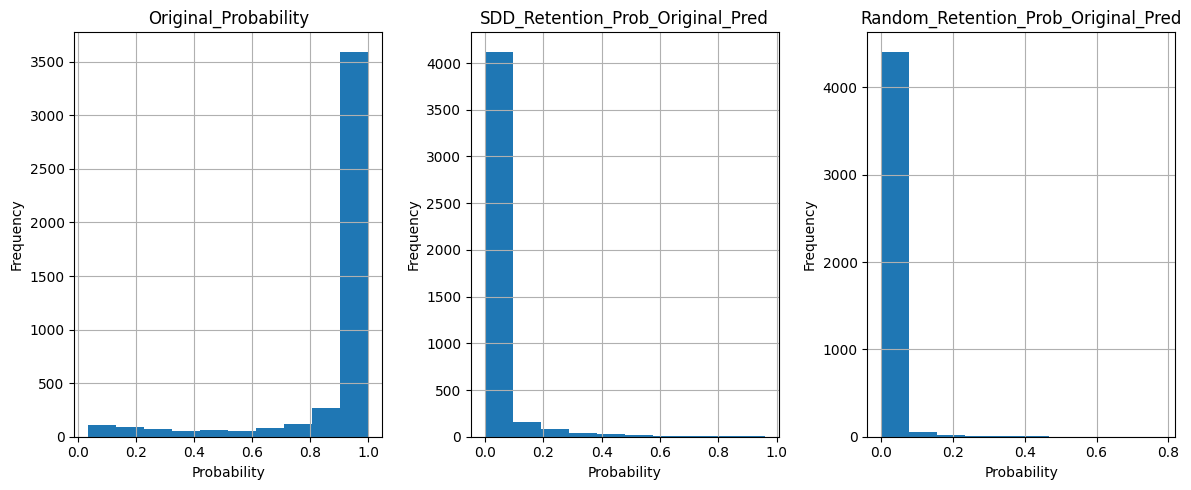

In [37]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

df_2['Original_Prob'].hist(bins=10, ax=axes[0])
axes[0].set_title('Original_Probability')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')


df_2['SDD_Pertb_Prob_Original_Pred'].hist(bins=10, ax=axes[1])
axes[1].set_title('SDD_Retention_Prob_Original_Pred')
axes[1].set_xlabel('Probability')
axes[1].set_ylabel('Frequency')


df_2['Random_Pertb_Prob_Original_Pred'].hist(bins=10, ax=axes[2])
axes[2].set_title('Random_Retention_Prob_Original_Pred')
axes[2].set_xlabel('Probability')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

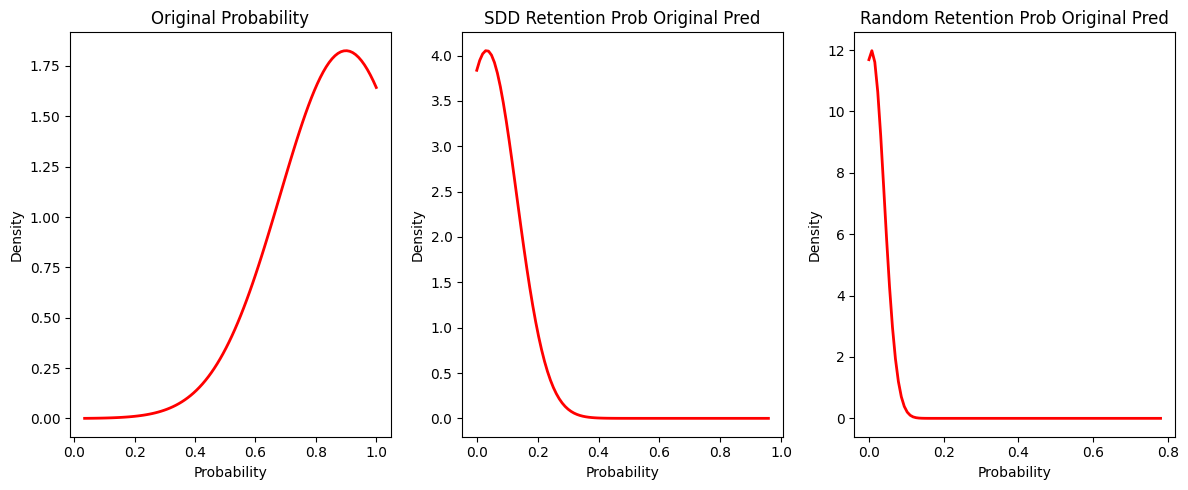

In [38]:
import scipy.stats as stats

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# List of column names and titles
columns = ['Original_Prob', 'SDD_Pertb_Prob_Original_Pred', 'Random_Pertb_Prob_Original_Pred']
titles = ['Original Probability', 'SDD Retention Prob Original Pred', 'Random Retention Prob Original Pred']

for i, col in enumerate(columns):
    # Compute mean and standard deviation
    mean, std = df_2[col].mean(), df_2[col].std()

    # Generate x values for the bell curve
    x = np.linspace(df_2[col].min(), df_2[col].max(), 100)
    y = stats.norm.pdf(x, mean, std)

    # Plot bell curve
    axes[i].plot(x, y, 'r-', lw=2)

    # Set labels
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [36]:
# Value in the 2nd column (column index 1)
value_in_column_1 = 'Orlando_Bloom_88510_45958.jpeg'

# Retrieve the row where the 2nd column matches the value
row = df[df.iloc[:, 0] == value_in_column_1]

# Print the row
print(row)

                               Image  Original_Prediction  Original_Prob  \
1274  Orlando_Bloom_88510_45958.jpeg                  134       0.997395   

      SDD_Pertb_Prediction  SDD_Pertb_Prob  SDD_Pertb_Prob_Original_Pred  \
1274                   134        0.239996                      0.239996   

      Random_Pertb_Prediction  Random_Pertb_Prob  \
1274                      134             0.9937   

      Random_Pertb_Prob_Original_Pred  
1274                           0.9937  
